[init] Using pH0 = 7.360 → strong-ion net (Na+ - Cl-) = 0.0000 M
[fit] Optimizing parameters ...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7598e+00                                    1.60e-01    
       1              2         7.5748e-01      1.00e+00       4.22e+00       5.79e-01    
[warn] simulation failure at a=0.011325226031315833, kd=0.004997909703855317, ts=18.830124276157495, tau=0.0, kLa=0.0: Values in `t_eval` are not properly sorted.
       2              5         5.3036e-01      2.27e-01       5.61e-02       6.09e-01    
       3              6         2.8162e-01      2.49e-01       3.14e-01       2.32e+03    
       4              7         2.6602e-01      1.56e-02       3.72e+00       6.12e-01    
       5              8         2.4690e-01      1.91e-02       9.41e-02       3.27e+03    
       6             10         2.1810e-01      2.88e-02       2.79e-02       5.77e-01    
       7    

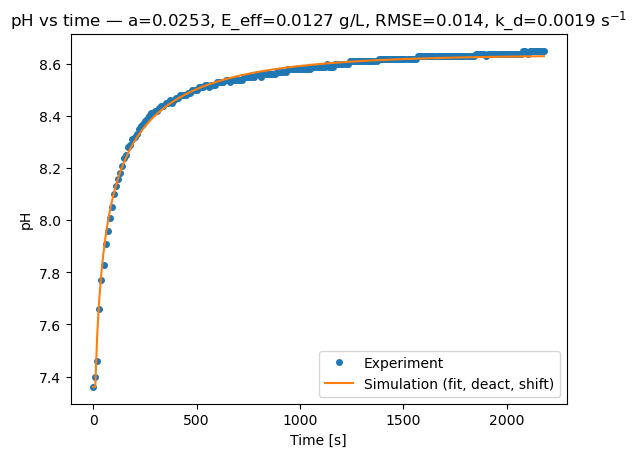

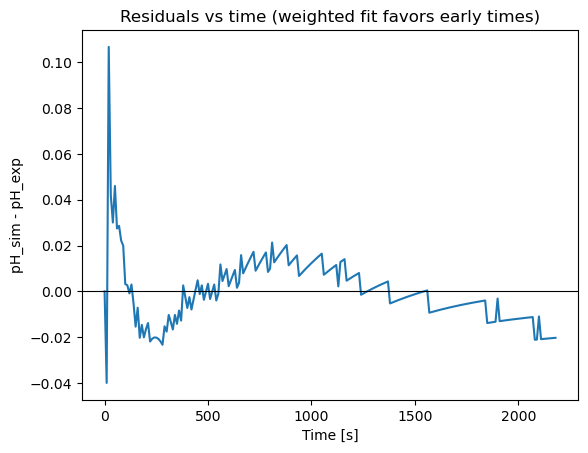

In [7]:
 # Fit urease activity to experimental pH(t) using the "new" simulator
# (Kp(pH) table, isothermal 40 °C, strong-ion pH). Optional knobs:
#   - first-order enzyme deactivation (k_deact)
#   - small time shift (t_shift) and probe first-order lag (tau_probe)
#   - optional NH3 stripping (fit or fixed), CO2 kept closed by default
#
# Outputs a timestamped folder with: overlay plot, residual plot,
# fitted pH series, and a dense species/conversion CSV.

import os, sys, math, json
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar, least_squares

# ╔══════════════════════════════════════════════════════════════╗
# ║                       USER SETTINGS                          ║
# ╚══════════════════════════════════════════════════════════════╝

# --- Experimental data ---
exp_csv_path = "/Volumes/01785304894/Data/NPG-Urea-20mM-Urease/urea_urease/urease=0,087gr_urea=20mM_T=40C/pH/2nd_20mM_Urea_0,87g_Urease.csv"  # <-- set this
time_to_seconds = 1.0           # 1.0 if CSV time is seconds; 60.0 if minutes→seconds
TIME_COL_HINTS = ["time", "t"]
PH_COL_HINTS   = ["ph"]

# --- Reactor & enzyme (mass-based) ---
volume_L               = 0.2
grams_urease_powder    = 0.10
powder_activity_frac   = 1.0   # MASS purity (0–1). Leave 1.0 unless you know purity.
E_loading_base_g_per_L = grams_urease_powder * powder_activity_frac / volume_L  # g/L

# We will fit an "activity_scale" that multiplies this E_loading_base_g_per_L.
# (Mathematically equivalent to scaling k0; choosing one avoids non-identifiability.)

# --- Chemistry (no CO2 steering) ---
S0         = 0.020   # urea [M]
N0         = 0.0     # total ammonia [M]
C0         = 0.0     # total inorganic carbon [M]
Pt_total_M = 0.0     # phosphate [M]; keep 0 to disable inhibition

# --- Temperature (isothermal) ---
T_isothermal_K = 313.15  # 40 °C

# --- Initial pH control ---
# If None: use the first experimental pH to set B_STRONG; else enforce this number.
initial_pH = 7.36

# --- Fitting switches (turn on the effects you want the optimizer to include) ---
fit_activity = True      # scale factor multiplying E_loading_base_g_per_L
fit_k_deact  = True      # first-order enzyme deactivation (s^-1)
fit_t_shift  = True      # small time shift (s): model evaluated at t = t_exp - t_shift
fit_tau_probe = False    # 1st-order probe lag (s): measured pH follows true pH
# NH3 volatilization (open beaker effect). CO2 kept closed by default.
strip_NH3      = False   # if True, include NH3 loss with kLa_NH3_s (fixed or fitted)
fit_kLa_NH3    = False   # fit kLa_NH3_s if True; else use kLa_NH3_s_fixed
kLa_NH3_s_fixed = 0.0    # 1/s (reasonable range 0.001–0.02); only used if strip_NH3=True and fit_kLa_NH3=False

# --- Bounds & initial guesses ---
activity_bounds = (1e-4, 100.0)   # multiplies mass loading
k_deact_bounds  = (0.0, 5e-3)     # s^-1  (0 → hours timescale)
t_shift_bounds  = (-10.0, 60.0)   # s
tau_bounds      = (0.0, 60.0)     # s (0 disables probe lag)
kLa_bounds      = (0.0, 5e-2)     # s^-1

activity_initial_guess = 1.0
k_deact_initial_guess  = 0.0
t_shift_initial_guess  = 0.0
tau_initial_guess      = 0.0
kLa_initial_guess      = 0.003    # if fit_kLa_NH3=True

# --- Early-time weighting (emphasize initial slope & "elbow") ---
t_weight      = 400.0   # seconds where weight ~1/2
weight_power  = 2.0     # larger → more emphasis on early data

# --- Optimizer robustness ---
robust_loss   = 'soft_l1'  # 'linear' for plain least squares
f_scale_ph    = 0.03       # robust scale in pH units

# --- Output folder (auto) ---
exp_tag = Path(exp_csv_path).stem or "data"
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = Path(f"fit_out_{exp_tag}_{ts}")
out_dir.mkdir(parents=True, exist_ok=True)

# ╔══════════════════════════════════════════════════════════════╗
# ║                  CONSTANTS & PARAMETERS                      ║
# ╚══════════════════════════════════════════════════════════════╝

R   = 8.314  # J/mol/K

# Kinetics (Qin & Cabral, per gram of enzyme)
k0_mol_per_s_per_g = 0.267   # mol NH3/(s·g)
Ea    = 29.1e3               # J/mol
KM, Ks = 2.56e-3, 6.18       # M

# pH-activity (two-site)
pKa_es1, pKa_es2 = 9.07, 5.62
Kes1, Kes2 = 10**(-pKa_es1), 10**(-pKa_es2)
alpha_e, beta_e = 0.373, 0.564

# Product inhibition Kp(pH) (table-based, clamped)
_KP_POINTS = [
    (6.25, 0.1785),
    (6.50, 0.1194),
    (7.00, 0.0693),
    (7.50, 0.0386),
    (8.00, 0.0311),
    (8.50, 0.0327),
    (8.75, 0.0298),
    (9.00, 0.0310),
]
def Kp_of_pH(pH):
    pts = _KP_POINTS
    if pH <= pts[0][0]: return pts[0][1]
    if pH >= pts[-1][0]: return pts[-1][1]
    for (pa, Ka), (pb, Kb) in zip(pts, pts[1:]):
        if pa <= pH <= pb:
            w = (pH - pa) / (pb - pa)
            return Ka + w * (Kb - Ka)
    return pts[-1][1]

# Optional competitive phosphate (inactive by default)
Ki_phosphate = 0.010

# Acid–base constants
Kw     = 1e-14
Ka_NH4 = 5.62e-10
Ka1    = 4.45e-7
Ka2    = 4.69e-11
Ka1p   = 7.11e-3
Ka2p   = 6.32e-8
Ka3p   = 4.22e-13

# ╔══════════════════════════════════════════════════════════════╗
# ║       STRONG-ION BACKGROUND (Na+ - Cl-) FOR INITIAL pH       ║
# ╚══════════════════════════════════════════════════════════════╝

B_STRONG = 0.0

def _B_for_target_pH(pH_target, Ntot, Ctot, Ptot):
    H  = 10**(-pH_target)
    OH = Kw / H
    NH4 = Ntot * (H / (H + Ka_NH4))
    denom_c = H*H + Ka1*H + Ka1*Ka2
    HCO3 = Ctot * (Ka1 * H / denom_c)
    CO3  = Ctot * (Ka1 * Ka2 / denom_c)
    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)
    return (OH + HCO3 + 2*CO3 + H2PO4 + 2*HPO4 + 3*PO4) - (H + NH4)

# ╔══════════════════════════════════════════════════════════════╗
# ║              SPECIATION & pH (charge balance)                ║
# ╚══════════════════════════════════════════════════════════════╝

_SPEC_LAST_LOGH = {"val": 7.0}

def _charge_balance(logH, Ntot, Ctot, Ptot):
    H  = 10**(-logH)
    OH = Kw / H
    NH4 = Ntot * (H / (H + Ka_NH4))
    denom_c = H*H + Ka1*H + Ka1*Ka2
    HCO3 = Ctot * (Ka1 * H / denom_c)
    CO3  = Ctot * (Ka1 * Ka2 / denom_c)
    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)
    return (H + NH4) - (OH + HCO3 + 2*CO3 + H2PO4 + 2*HPO4 + 3*PO4) + B_STRONG

def compute_speciation(Ntot, Ctot, Ptot):
    Ntot = max(Ntot, 0.0); Ctot = max(Ctot, 0.0); Ptot = max(Ptot, 0.0)
    lo = max(1.0, _SPEC_LAST_LOGH["val"] - 3.0)
    hi = min(13.0, _SPEC_LAST_LOGH["val"] + 3.0)
    f_lo = _charge_balance(lo, Ntot, Ctot, Ptot)
    f_hi = _charge_balance(hi, Ntot, Ctot, Ptot)
    if f_lo * f_hi > 0: lo, hi = 1.0, 13.0
    sol = root_scalar(_charge_balance, bracket=[lo, hi], method='brentq',
                      args=(Ntot, Ctot, Ptot))
    logH = sol.root
    _SPEC_LAST_LOGH["val"] = logH
    H  = 10**(-logH); OH = Kw / H
    NH4 = Ntot * (H / (H + Ka_NH4)); NH3 = Ntot - NH4
    denom_c = H*H + Ka1*H + Ka1*Ka2
    CO2  = Ctot * (H*H / denom_c)
    HCO3 = Ctot * (Ka1 * H / denom_c)
    CO3  = Ctot * (Ka1 * Ka2 / denom_c)
    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)
    return {'pH': -math.log10(H), 'H': H, 'OH': OH,
            'NH3': NH3, 'NH4': NH4,
            'CO2': CO2, 'HCO3': HCO3, 'CO3': CO3,
            'H2PO4': H2PO4, 'HPO4': HPO4, 'PO4': PO4}

# ╔══════════════════════════════════════════════════════════════╗
# ║                        RATE LAW                              ║
# ╚══════════════════════════════════════════════════════════════╝

def rate_per_g(S, Ntot, pH, T, P_inhib):
    """NH3 formation rate per gram of urease [mol/(g·s)]."""
    S = max(S, 0.0)
    H = 10**(-pH)
    kT = k0_mol_per_s_per_g * math.exp(-Ea / (R * T))
    pH_factor = 1.0 / (1.0 + (Kes1/H)**alpha_e + (H/Kes2)**beta_e)
    alpha_comp = 1.0 + (P_inhib / Ki_phosphate if Ki_phosphate > 0.0 else 0.0)
    denom = max(KM * alpha_comp + S + (S*S)/Ks, 1e-12)
    v_sub = kT * pH_factor * (S / denom)
    return v_sub / (1.0 + max(Ntot,0.0) / Kp_of_pH(pH))

def make_rhs_isothermal(E0_g_per_L, k_deact_per_s=0.0,
                        use_strip_NH3=False, kLa_NH3_s=0.0):
    """Build RHS(t,y) with optional 1st-order deactivation and NH3 stripping."""
    def rhs(t, y):
        S, Ntot, Ctot = y
        sp  = compute_speciation(Ntot, Ctot, Pt_total_M)
        pH  = sp['pH']
        P_inhib = 0.0  # add H2PO4-/HPO4 if you set Pt_total_M>0
        per_g = rate_per_g(S, Ntot, pH, T_isothermal_K, P_inhib)
        # active enzyme (g/L)
        E_active = E0_g_per_L * math.exp(-max(k_deact_per_s,0.0) * max(t,0.0))
        r_NH3 = per_g * E_active                     # mol/L/s produced
        # gas loss (mol/L/s)
        r_strp_NH3 = (kLa_NH3_s * sp['NH3']) if use_strip_NH3 else 0.0
        dS_dt = -0.5 * r_NH3
        dN_dt =        r_NH3 - r_strp_NH3
        dC_dt =  0.5 * r_NH3
        return [dS_dt, dN_dt, dC_dt]
    return rhs

# ╔══════════════════════════════════════════════════════════════╗
# ║                LOAD EXP DATA & INITIALIZE B_STRONG           ║
# ╚══════════════════════════════════════════════════════════════╝

def _detect_col(df, hints):
    for h in hints:
        for c in df.columns:
            if h in str(c).lower():
                return c
    return None

exp_df = pd.read_csv(exp_csv_path, sep=None, engine="python")
time_col = _detect_col(exp_df, TIME_COL_HINTS)
ph_col   = _detect_col(exp_df, PH_COL_HINTS)
if time_col is None or ph_col is None:
    raise ValueError(f"Could not detect time/pH columns in {exp_csv_path}. Columns: {list(exp_df.columns)}")

exp_times = np.asarray(exp_df[time_col], dtype=float) * time_to_seconds
exp_pH    = np.asarray(exp_df[ph_col], dtype=float)
mask = np.isfinite(exp_times) & np.isfinite(exp_pH)
exp_times = exp_times[mask]
exp_pH    = exp_pH[mask]
order = np.argsort(exp_times)
exp_times = exp_times[order]
exp_pH    = exp_pH[order]

# Initialize B_STRONG from first pH (or user override)
pH0_for_B = exp_pH[0] if initial_pH is None else float(initial_pH)
B_STRONG = _B_for_target_pH(pH0_for_B, N0, C0, Pt_total_M)
_SPEC_LAST_LOGH["val"] = pH0_for_B
print(f"[init] Using pH0 = {pH0_for_B:.3f} → strong-ion net (Na+ - Cl-) = {B_STRONG:.4f} M")

# ╔══════════════════════════════════════════════════════════════╗
# ║                       SIMULATION API                         ║
# ╚══════════════════════════════════════════════════════════════╝

def simulate_pH_curve(activity_scale, times_s,
                      k_deact=0.0, t_shift=0.0, tau_probe=0.0,
                      use_strip=False, kLa_NH3_s=0.0):
    """
    Return pH(times_s) with options:
      - activity_scale multiplies enzyme loading (g/L)
      - k_deact (s^-1) first-order deactivation
      - t_shift (s) model evaluated at t = max(t - t_shift, 0)
      - tau_probe (s) 1st-order lag applied to pH
      - NH3 stripping optionally included with kLa_NH3_s (1/s)
    """
    t_model = np.clip(times_s - t_shift, 0.0, None)
    E0 = max(activity_scale, 0.0) * E_loading_base_g_per_L
    rhs = make_rhs_isothermal(E0, k_deact_per_s=max(k_deact,0.0),
                              use_strip_NH3=use_strip, kLa_NH3_s=max(kLa_NH3_s,0.0))
    y0 = [S0, N0, C0]
    sol = solve_ivp(rhs, [t_model[0], t_model[-1]], y0, method='BDF',
                    t_eval=t_model, max_step=60.0, rtol=1e-6, atol=1e-12)
    if not sol.success:
        raise RuntimeError(f"Integration failed: {sol.message}")

    # convert totals → pH
    pH_true = np.empty_like(t_model, dtype=float)
    for i in range(len(t_model)):
        _, Ntot, Ctot = sol.y[:, i]
        sp = compute_speciation(Ntot, Ctot, Pt_total_M)
        pH_true[i] = sp['pH']

    if tau_probe <= 0.0:
        return pH_true

    # apply 1st-order lag to pH (discrete exact update)
    pH_meas = np.empty_like(pH_true, dtype=float)
    pH_meas[0] = pH_true[0]
    for i in range(1, len(t_model)):
        dt = t_model[i] - t_model[i-1]
        a = math.exp(-dt / max(tau_probe, 1e-12))
        pH_meas[i] = a * pH_meas[i-1] + (1 - a) * pH_true[i]
    return pH_meas

# ╔══════════════════════════════════════════════════════════════╗
# ║                 LEAST-SQUARES FIT WITH WEIGHTING             ║
# ╚══════════════════════════════════════════════════════════════╝

def time_weights(t):
    return 1.0 / (1.0 + (np.maximum(t,0.0)/max(t_weight,1e-9))**weight_power)

# Build parameter vector & bounds
params0   = []
lb, ub    = [], []

def _add_param(flag, x0, lo, hi):
    if flag:
        params0.append(x0); lb.append(lo); ub.append(hi)

# Order: [activity, k_deact, t_shift, tau, kLaNH3]
_add_param(fit_activity, activity_initial_guess, *activity_bounds)
_add_param(fit_k_deact,   k_deact_initial_guess, *k_deact_bounds)
_add_param(fit_t_shift,   t_shift_initial_guess, *t_shift_bounds)
_add_param(fit_tau_probe, tau_initial_guess,     *tau_bounds)
_add_param(strip_NH3 and fit_kLa_NH3, kLa_initial_guess, *kLa_bounds)

def _unpack(x):
    idx = 0
    a  = x[idx] if fit_activity else 1.0; idx += 1 if fit_activity else 0
    kd = x[idx] if fit_k_deact  else 0.0; idx += 1 if fit_k_deact  else 0
    ts = x[idx] if fit_t_shift  else 0.0; idx += 1 if fit_t_shift  else 0
    tau= x[idx] if fit_tau_probe else 0.0; idx += 1 if fit_tau_probe else 0
    kLa= x[idx] if (strip_NH3 and fit_kLa_NH3) else (kLa_NH3_s_fixed if strip_NH3 else 0.0)
    return a, kd, ts, tau, kLa

def residuals(x):
    a, kd, ts, tau, kLa = _unpack(x)
    try:
        sim = simulate_pH_curve(a, exp_times, k_deact=kd, t_shift=ts, tau_probe=tau,
                                use_strip=strip_NH3, kLa_NH3_s=kLa)
    except Exception as e:
        # If integration fails, return a big penalty
        print(f"[warn] simulation failure at a={a}, kd={kd}, ts={ts}, tau={tau}, kLa={kLa}: {e}")
        return np.full_like(exp_pH, 1e6)
    w = time_weights(exp_times)
    return np.sqrt(w) * (sim - exp_pH)

if len(params0) == 0:
    raise RuntimeError("Nothing to fit. Enable at least one fit_* switch.")

print("[fit] Optimizing parameters ...")
res = least_squares(
    residuals,
    x0=np.array(params0, dtype=float),
    bounds=(np.array(lb, dtype=float), np.array(ub, dtype=float)),
    method='trf',
    xtol=1e-8, ftol=1e-8, gtol=1e-8,
    loss=robust_loss, f_scale=f_scale_ph,
    verbose=2
)

best = res.x
best_activity, best_kd, best_tshift, best_tau, best_kLa = _unpack(best)

# Evaluate best fit (measured and true)
sim_pH_best_meas = simulate_pH_curve(best_activity, exp_times,
                                     k_deact=best_kd, t_shift=best_tshift,
                                     tau_probe=best_tau,
                                     use_strip=strip_NH3, kLa_NH3_s=best_kLa)
sim_pH_best_true = simulate_pH_curve(best_activity, exp_times,
                                     k_deact=best_kd, t_shift=best_tshift,
                                     tau_probe=0.0,
                                     use_strip=strip_NH3, kLa_NH3_s=best_kLa)

rmse = np.sqrt(np.mean((sim_pH_best_meas - exp_pH)**2))
mae  = np.mean(np.abs(sim_pH_best_meas - exp_pH))

print("\n[fit] Results")
print(f"  activity_scale     = {best_activity:.6g}")
print(f"  E_eff (g/L)        = {best_activity * E_loading_base_g_per_L:.6g} (base {E_loading_base_g_per_L:.6g})")
if fit_k_deact:  print(f"  k_deact (s^-1)     = {best_kd:.6g}  (~{3600*best_kd:.3g} h^-1)")
if fit_t_shift:  print(f"  t_shift (s)        = {best_tshift:.3g}")
if fit_tau_probe:print(f"  tau_probe (s)      = {best_tau:.3g}")
if strip_NH3:    print(f"  kLa_NH3 (s^-1)     = {best_kLa:.6g} {'(fitted)' if fit_kLa_NH3 else '(fixed)'}")
print(f"  RMSE               = {rmse:.4f} pH units,  MAE = {mae:.4f} pH units")

# ╔══════════════════════════════════════════════════════════════╗
# ║                      SAVE FIT & PLOTS                        ║
# ╚══════════════════════════════════════════════════════════════╝

# Save fit summary
summary = {
    "fit": {
        "activity_scale": best_activity,
        "E_eff_g_per_L": best_activity * E_loading_base_g_per_L,
        "k_deact_s^-1": best_kd if fit_k_deact else 0.0,
        "t_shift_s": best_tshift if fit_t_shift else 0.0,
        "tau_probe_s": best_tau if fit_tau_probe else 0.0,
        "kLa_NH3_s^-1": best_kLa if strip_NH3 else 0.0,
        "RMSE_pH": rmse, "MAE_pH": mae
    },
    "settings": {
        "volume_L": volume_L,
        "grams_urease_powder": grams_urease_powder,
        "powder_activity_frac": powder_activity_frac,
        "E_loading_base_g_per_L": E_loading_base_g_per_L,
        "S0_M": S0, "N0_M": N0, "C0_M": C0,
        "T_isothermal_K": T_isothermal_K,
        "initial_pH_for_B": pH0_for_B,
        "strip_NH3": strip_NH3,
    }
}
(out_dir / "fit_summary.json").write_text(json.dumps(summary, indent=2))

# Overlay plot
plt.figure()
plt.plot(exp_times, exp_pH, 'o', label='Experiment', markersize=4)
lbl = "Simulation (fit"
if fit_k_deact: lbl += ", deact"
if fit_t_shift: lbl += ", shift"
if fit_tau_probe: lbl += ", probe"
if strip_NH3: lbl += ", NH3 loss"
lbl += ")"
plt.plot(exp_times, sim_pH_best_meas, '-', label=lbl)
plt.xlabel("Time [s]"); plt.ylabel("pH")
title = (f"pH vs time — a={best_activity:.3g}, "
         f"E_eff={best_activity*E_loading_base_g_per_L:.3g} g/L, RMSE={rmse:.3f}")
if fit_k_deact: title += f", k_d={best_kd:.2g} s$^{{-1}}$"
if strip_NH3:   title += f", kLa={best_kLa:.3g} s$^{{-1}}$"
plt.title(title)
plt.legend()
plt.savefig(out_dir / "fit_ph_overlay.png", bbox_inches='tight', dpi=150)

# Residuals
plt.figure()
plt.plot(exp_times, sim_pH_best_meas - exp_pH, '-')
plt.xlabel("Time [s]"); plt.ylabel("pH_sim - pH_exp")
plt.title("Residuals vs time (weighted fit favors early times)")
plt.axhline(0, color='k', lw=0.8)
plt.savefig(out_dir / "fit_ph_residual.png", bbox_inches='tight', dpi=150)

# Save timeseries table
out_df = pd.DataFrame({
    "time_s": exp_times,
    "pH_exp": exp_pH,
    "pH_sim_measured": sim_pH_best_meas,
    "pH_sim_true": sim_pH_best_true,
    "residual_meas_minus_exp": sim_pH_best_meas - exp_pH,
    "weight": time_weights(exp_times)
})
out_df.to_csv(out_dir / "fit_results_sim_vs_exp.csv", index=False)

print(f"[out] wrote folder: {out_dir.resolve()}")

# ╔══════════════════════════════════════════════════════════════╗
# ║         DENSE SPECIES/CONVERSION USING BEST-FIT PARAMS       ║
# ╚══════════════════════════════════════════════════════════════╝

# Simulate on a dense grid from 0 to max experimental time
t_end = float(exp_times[-1])
dense_t = np.linspace(0.0, t_end, 1200)
rhs_best = make_rhs_isothermal(
    best_activity * E_loading_base_g_per_L,
    k_deact_per_s=(best_kd if fit_k_deact else 0.0),
    use_strip_NH3=strip_NH3, kLa_NH3_s=(best_kLa if strip_NH3 else 0.0)
)
y0 = [S0, N0, C0]
sol_dense = solve_ivp(rhs_best, [0.0, t_end], y0, method='BDF',
                      t_eval=dense_t, max_step=60.0, rtol=1e-6, atol=1e-12)
if not sol_dense.success:
    print(f"[warn] dense simulation failed: {sol_dense.message}")

# Build species dataframe
records = []
for t, S, Ntot, Ctot in zip(sol_dense.t, *sol_dense.y):
    sp = compute_speciation(Ntot, Ctot, Pt_total_M)
    records.append({
        "time_s": t,
        "urea_M": max(S, 0.0),
        "total_ammonia_M": max(Ntot, 0.0),
        "total_inorgC_M": max(Ctot, 0.0),
        "conversion_frac": (S0 - max(S,0.0)) / max(S0,1e-30),
        "pH": sp["pH"],
        "NH3_M": sp["NH3"],
        "NH4_M": sp["NH4"],
        "CO2_aq_M": sp["CO2"],
        "HCO3_M": sp["HCO3"],
        "CO3_2M": sp["CO3"]
    })
species_df = pd.DataFrame.from_records(records)
species_df.to_csv(out_dir / "species_time_series.csv", index=False)
print(f"[out] wrote species/conversion CSV: {out_dir / 'species_time_series.csv'}")


[init] Using pH0 = 7.360 → strong-ion net (Na+ - Cl-) = 0.0000 M
[fit] Optimizing parameters ...
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.7598e+00                                    1.60e-01    
       1              2         7.5748e-01      1.00e+00       4.22e+00       5.79e-01    
[warn] simulation failure at a=0.011325226031315833, kd=0.004997909703855317, ts=18.830124276157495, tau=0.0, kLa=0.0: Values in `t_eval` are not properly sorted.
       2              5         5.3036e-01      2.27e-01       5.61e-02       6.09e-01    
       3              6         2.8162e-01      2.49e-01       3.14e-01       2.32e+03    
       4              7         2.6602e-01      1.56e-02       3.72e+00       6.12e-01    
       5              8         2.4690e-01      1.91e-02       9.41e-02       3.27e+03    
       6             10         2.1810e-01      2.88e-02       2.79e-02       5.77e-01    
       7    

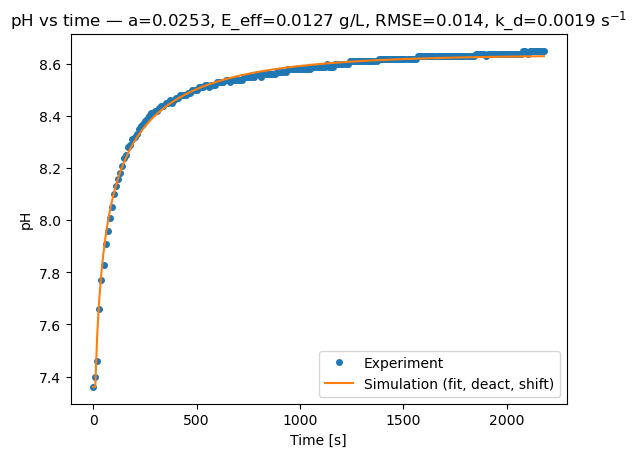

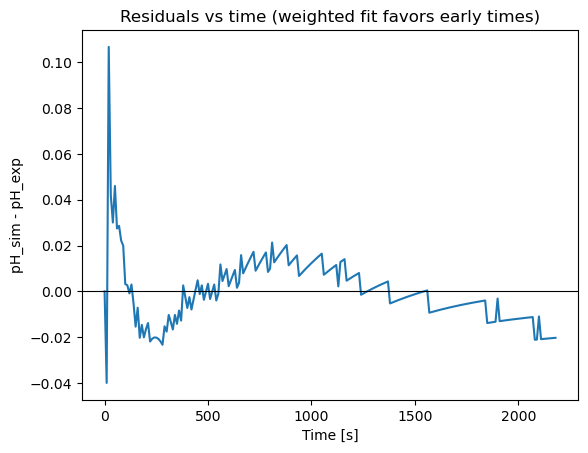

In [9]:
# Fit urease activity to experimental pH(t) using the "new" simulator
# (Kp(pH) table, isothermal 40 °C, strong-ion pH). Optional knobs:
#   - first-order enzyme deactivation (k_deact)
#   - small time shift (t_shift) and probe first-order lag (tau_probe)
#   - optional NH3 stripping (fit or fixed), CO2 kept closed by default
#
# Outputs a timestamped folder with: overlay plot, residual plot,
# fitted pH series, and a species/conversion CSV.  NEW: option to
# extend the species CSV until (near) full conversion.

import os, sys, math, json
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import root_scalar, least_squares

# ╔══════════════════════════════════════════════════════════════╗
# ║                       USER SETTINGS                          ║
# ╚══════════════════════════════════════════════════════════════╝

# --- Experimental data ---
exp_csv_path = "/Volumes/01785304894/Data/NPG-Urea-20mM-Urease/urea_urease/urease=0,087gr_urea=20mM_T=40C/pH/2nd_20mM_Urea_0,87g_Urease.csv"  # <-- set this
time_to_seconds = 1.0           # 1.0 if CSV time is seconds; 60.0 if minutes→seconds
TIME_COL_HINTS = ["time", "t"]
PH_COL_HINTS   = ["ph"]

# --- Reactor & enzyme (mass-based) ---
volume_L               = 0.2
grams_urease_powder    = 0.10
powder_activity_frac   = 1.0   # MASS purity (0–1). Leave 1.0 unless you know purity.
E_loading_base_g_per_L = grams_urease_powder * powder_activity_frac / volume_L  # g/L

# We'll fit an "activity_scale" that multiplies this mass loading.

# --- Chemistry (no CO2 steering) ---
S0         = 0.020   # urea [M]
N0         = 0.0     # total ammonia [M]
C0         = 0.0     # total inorganic carbon [M]
Pt_total_M = 0.0     # phosphate [M]; keep 0 to disable inhibition

# --- Temperature (isothermal) ---
T_isothermal_K = 313.15  # 40 °C

# --- Initial pH control ---
# If None: use the first experimental pH to set B_STRONG; else enforce this number.
initial_pH = 7.36

# --- Fitting switches (turn on the effects you want the optimizer to include) ---
fit_activity  = True      # scale factor multiplying E_loading_base_g_per_L
fit_k_deact   = True      # first-order enzyme deactivation (s^-1)
fit_t_shift   = True      # small time shift (s): model evaluated at t = t_exp - t_shift
fit_tau_probe = False     # 1st-order probe lag (s)
# NH3 volatilization (open beaker effect). CO2 kept closed by default.
strip_NH3        = False   # if True, include NH3 loss with kLa_NH3_s (fixed or fitted)
fit_kLa_NH3      = False   # fit kLa_NH3_s if True; else use kLa_NH3_s_fixed
kLa_NH3_s_fixed  = 0.0     # 1/s; used if strip_NH3=True and fit_kLa_NH3=False

# --- Bounds & initial guesses ---
activity_bounds = (1e-4, 100.0)   # multiplies mass loading
k_deact_bounds  = (0.0, 5e-3)     # s^-1
t_shift_bounds  = (-10.0, 60.0)   # s
tau_bounds      = (0.0, 60.0)     # s
kLa_bounds      = (0.0, 5e-2)     # s^-1

activity_initial_guess = 1.0
k_deact_initial_guess  = 0.0
t_shift_initial_guess  = 0.0
tau_initial_guess      = 0.0
kLa_initial_guess      = 0.003    # if fit_kLa_NH3=True

# --- Early-time weighting (emphasize initial slope & "elbow") ---
t_weight      = 400.0   # seconds where weight ~1/2
weight_power  = 2.0     # larger → more emphasis on early data

# --- Optimizer robustness ---
robust_loss   = 'soft_l1'  # 'linear' for plain least squares
f_scale_ph    = 0.03       # robust scale in pH units

# --- Output folder (auto) ---
exp_tag = Path(exp_csv_path).stem or "data"
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = Path(f"fit_out_{exp_tag}_{ts}")
out_dir.mkdir(parents=True, exist_ok=True)

# --- NEW: Species timeseries extension controls ---
species_to_full_conversion   = True     # if True, integrate species until depletion (or timeout)
species_urea_cut_frac        = 1e-6     # define "depleted": S < cut_frac*S0
species_tmax_if_no_conv_s    = 24*3600  # safety cap if deactivation prevents full conversion

# ╔══════════════════════════════════════════════════════════════╗
# ║                  CONSTANTS & PARAMETERS                      ║
# ╚══════════════════════════════════════════════════════════════╝

R   = 8.314  # J/mol/K

# Kinetics (Qin & Cabral, per gram of enzyme)
k0_mol_per_s_per_g = 0.267   # mol NH3/(s·g)
Ea    = 29.1e3               # J/mol
KM, Ks = 2.56e-3, 6.18       # M

# pH-activity (two-site)
pKa_es1, pKa_es2 = 9.07, 5.62
Kes1, Kes2 = 10**(-pKa_es1), 10**(-pKa_es2)
alpha_e, beta_e = 0.373, 0.564

# Product inhibition Kp(pH) (table-based, clamped)
_KP_POINTS = [
    (6.25, 0.1785),
    (6.50, 0.1194),
    (7.00, 0.0693),
    (7.50, 0.0386),
    (8.00, 0.0311),
    (8.50, 0.0327),
    (8.75, 0.0298),
    (9.00, 0.0310),
]
def Kp_of_pH(pH):
    pts = _KP_POINTS
    if pH <= pts[0][0]: return pts[0][1]
    if pH >= pts[-1][0]: return pts[-1][1]
    for (pa, Ka), (pb, Kb) in zip(pts, pts[1:]):
        if pa <= pH <= pb:
            w = (pH - pa) / (pb - pa)
            return Ka + w * (Kb - Ka)
    return pts[-1][1]

# Optional competitive phosphate (inactive by default)
Ki_phosphate = 0.010

# Acid–base constants
Kw     = 1e-14
Ka_NH4 = 5.62e-10
Ka1    = 4.45e-7
Ka2    = 4.69e-11
Ka1p   = 7.11e-3
Ka2p   = 6.32e-8
Ka3p   = 4.22e-13

# ╔══════════════════════════════════════════════════════════════╗
# ║       STRONG-ION BACKGROUND (Na+ - Cl-) FOR INITIAL pH       ║
# ╚══════════════════════════════════════════════════════════════╝

B_STRONG = 0.0

def _B_for_target_pH(pH_target, Ntot, Ctot, Ptot):
    H  = 10**(-pH_target)
    OH = Kw / H
    NH4 = Ntot * (H / (H + Ka_NH4))
    denom_c = H*H + Ka1*H + Ka1*Ka2
    HCO3 = Ctot * (Ka1 * H / denom_c)
    CO3  = Ctot * (Ka1 * Ka2 / denom_c)
    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)
    return (OH + HCO3 + 2*CO3 + H2PO4 + 2*HPO4 + 3*PO4) - (H + NH4)

# ╔══════════════════════════════════════════════════════════════╗
# ║              SPECIATION & pH (charge balance)                ║
# ╚══════════════════════════════════════════════════════════════╝

_SPEC_LAST_LOGH = {"val": 7.0}

def _charge_balance(logH, Ntot, Ctot, Ptot):
    H  = 10**(-logH)
    OH = Kw / H
    NH4 = Ntot * (H / (H + Ka_NH4))
    denom_c = H*H + Ka1*H + Ka1*Ka2
    HCO3 = Ctot * (Ka1 * H / denom_c)
    CO3  = Ctot * (Ka1 * Ka2 / denom_c)
    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)
    return (H + NH4) - (OH + HCO3 + 2*CO3 + H2PO4 + 2*HPO4 + 3*PO4) + B_STRONG

def compute_speciation(Ntot, Ctot, Ptot):
    Ntot = max(Ntot, 0.0); Ctot = max(Ctot, 0.0); Ptot = max(Ptot, 0.0)
    lo = max(1.0, _SPEC_LAST_LOGH["val"] - 3.0)
    hi = min(13.0, _SPEC_LAST_LOGH["val"] + 3.0)
    f_lo = _charge_balance(lo, Ntot, Ctot, Ptot)
    f_hi = _charge_balance(hi, Ntot, Ctot, Ptot)
    if f_lo * f_hi > 0: lo, hi = 1.0, 13.0
    sol = root_scalar(_charge_balance, bracket=[lo, hi], method='brentq',
                      args=(Ntot, Ctot, Ptot))
    logH = sol.root
    _SPEC_LAST_LOGH["val"] = logH
    H  = 10**(-logH); OH = Kw / H
    NH4 = Ntot * (H / (H + Ka_NH4)); NH3 = Ntot - NH4
    denom_c = H*H + Ka1*H + Ka1*Ka2
    CO2  = Ctot * (H*H / denom_c)
    HCO3 = Ctot * (Ka1 * H / denom_c)
    CO3  = Ctot * (Ka1 * Ka2 / denom_c)
    Dp   = H**3 + Ka1p*H**2 + Ka1p*Ka2p*H + Ka1p*Ka2p*Ka3p
    H2PO4 = Ptot * (Ka1p * H**2 / Dp)
    HPO4  = Ptot * (Ka1p * Ka2p * H / Dp)
    PO4   = Ptot * (Ka1p * Ka2p * Ka3p / Dp)
    return {'pH': -math.log10(H), 'H': H, 'OH': OH,
            'NH3': NH3, 'NH4': NH4,
            'CO2': CO2, 'HCO3': HCO3, 'CO3': CO3,
            'H2PO4': H2PO4, 'HPO4': HPO4, 'PO4': PO4}

# ╔══════════════════════════════════════════════════════════════╗
# ║                        RATE LAW                              ║
# ╚══════════════════════════════════════════════════════════════╝

def rate_per_g(S, Ntot, pH, T, P_inhib):
    """NH3 formation rate per gram of urease [mol/(g·s)]."""
    S = max(S, 0.0)
    H = 10**(-pH)
    kT = k0_mol_per_s_per_g * math.exp(-Ea / (R * T))
    pH_factor = 1.0 / (1.0 + (Kes1/H)**alpha_e + (H/Kes2)**beta_e)
    alpha_comp = 1.0 + (P_inhib / Ki_phosphate if Ki_phosphate > 0.0 else 0.0)
    denom = max(KM * alpha_comp + S + (S*S)/Ks, 1e-12)
    v_sub = kT * pH_factor * (S / denom)
    return v_sub / (1.0 + max(Ntot,0.0) / Kp_of_pH(pH))

def make_rhs_isothermal(E0_g_per_L, k_deact_per_s=0.0,
                        use_strip_NH3=False, kLa_NH3_s=0.0):
    """Build RHS(t,y) with optional 1st-order deactivation and NH3 stripping."""
    def rhs(t, y):
        S, Ntot, Ctot = y
        sp  = compute_speciation(Ntot, Ctot, Pt_total_M)
        pH  = sp['pH']
        P_inhib = 0.0  # add H2PO4-/HPO4 if you set Pt_total_M>0
        per_g = rate_per_g(S, Ntot, pH, T_isothermal_K, P_inhib)
        # active enzyme (g/L)
        E_active = E0_g_per_L * math.exp(-max(k_deact_per_s,0.0) * max(t,0.0))
        r_NH3 = per_g * E_active                     # mol/L/s produced
        # gas loss (mol/L/s)
        r_strp_NH3 = (kLa_NH3_s * sp['NH3']) if use_strip_NH3 else 0.0
        dS_dt = -0.5 * r_NH3
        dN_dt =        r_NH3 - r_strp_NH3
        dC_dt =  0.5 * r_NH3
        return [dS_dt, dN_dt, dC_dt]
    return rhs

# ╔══════════════════════════════════════════════════════════════╗
# ║                LOAD EXP DATA & INITIALIZE B_STRONG           ║
# ╚══════════════════════════════════════════════════════════════╝

def _detect_col(df, hints):
    for h in hints:
        for c in df.columns:
            if h in str(c).lower():
                return c
    return None

exp_df = pd.read_csv(exp_csv_path, sep=None, engine="python")
time_col = _detect_col(exp_df, TIME_COL_HINTS)
ph_col   = _detect_col(exp_df, PH_COL_HINTS)
if time_col is None or ph_col is None:
    raise ValueError(f"Could not detect time/pH columns in {exp_csv_path}. Columns: {list(exp_df.columns)}")

exp_times = np.asarray(exp_df[time_col], dtype=float) * time_to_seconds
exp_pH    = np.asarray(exp_df[ph_col], dtype=float)
mask = np.isfinite(exp_times) & np.isfinite(exp_pH)
exp_times = exp_times[mask]
exp_pH    = exp_pH[mask]
order = np.argsort(exp_times)
exp_times = exp_times[order]
exp_pH    = exp_pH[order]

# Initialize B_STRONG from first pH (or user override)
pH0_for_B = exp_pH[0] if initial_pH is None else float(initial_pH)
B_STRONG = _B_for_target_pH(pH0_for_B, N0, C0, Pt_total_M)
_SPEC_LAST_LOGH["val"] = pH0_for_B
print(f"[init] Using pH0 = {pH0_for_B:.3f} → strong-ion net (Na+ - Cl-) = {B_STRONG:.4f} M")

# ╔══════════════════════════════════════════════════════════════╗
# ║                       SIMULATION API                         ║
# ╚══════════════════════════════════════════════════════════════╝

def simulate_pH_curve(activity_scale, times_s,
                      k_deact=0.0, t_shift=0.0, tau_probe=0.0,
                      use_strip=False, kLa_NH3_s=0.0):
    """
    Return pH(times_s) with options:
      - activity_scale multiplies enzyme loading (g/L)
      - k_deact (s^-1) first-order deactivation
      - t_shift (s) model evaluated at t = max(t - t_shift, 0)
      - tau_probe (s) 1st-order lag applied to pH
      - NH3 stripping optionally included with kLa_NH3_s (1/s)
    """
    t_model = np.clip(times_s - t_shift, 0.0, None)
    E0 = max(activity_scale, 0.0) * E_loading_base_g_per_L
    rhs = make_rhs_isothermal(E0, k_deact_per_s=max(k_deact,0.0),
                              use_strip_NH3=use_strip, kLa_NH3_s=max(kLa_NH3_s,0.0))
    y0 = [S0, N0, C0]
    sol = solve_ivp(rhs, [t_model[0], t_model[-1]], y0, method='BDF',
                    t_eval=t_model, max_step=60.0, rtol=1e-6, atol=1e-12)
    if not sol.success:
        raise RuntimeError(f"Integration failed: {sol.message}")

    # convert totals → pH
    pH_true = np.empty_like(t_model, dtype=float)
    for i in range(len(t_model)):
        _, Ntot, Ctot = sol.y[:, i]
        sp = compute_speciation(Ntot, Ctot, Pt_total_M)
        pH_true[i] = sp['pH']

    if tau_probe <= 0.0:
        return pH_true

    # apply 1st-order lag to pH (discrete exact update)
    pH_meas = np.empty_like(pH_true, dtype=float)
    pH_meas[0] = pH_true[0]
    for i in range(1, len(t_model)):
        dt = t_model[i] - t_model[i-1]
        a = math.exp(-dt / max(tau_probe, 1e-12))
        pH_meas[i] = a * pH_meas[i-1] + (1 - a) * pH_true[i]
    return pH_meas

# ╔══════════════════════════════════════════════════════════════╗
# ║                 LEAST-SQUARES FIT WITH WEIGHTING             ║
# ╚══════════════════════════════════════════════════════════════╝

def time_weights(t):
    return 1.0 / (1.0 + (np.maximum(t,0.0)/max(t_weight,1e-9))**weight_power)

# Build parameter vector & bounds
params0   = []
lb, ub    = [], []

def _add_param(flag, x0, lo, hi):
    if flag:
        params0.append(x0); lb.append(lo); ub.append(hi)

# Order: [activity, k_deact, t_shift, tau, kLaNH3]
_add_param(fit_activity, activity_initial_guess, *activity_bounds)
_add_param(fit_k_deact,   k_deact_initial_guess, *k_deact_bounds)
_add_param(fit_t_shift,   t_shift_initial_guess, *t_shift_bounds)
_add_param(fit_tau_probe, tau_initial_guess,     *tau_bounds)
_add_param(strip_NH3 and fit_kLa_NH3, kLa_initial_guess, *kLa_bounds)

def _unpack(x):
    idx = 0
    a  = x[idx] if fit_activity else 1.0; idx += 1 if fit_activity else 0
    kd = x[idx] if fit_k_deact  else 0.0; idx += 1 if fit_k_deact  else 0
    ts = x[idx] if fit_t_shift  else 0.0; idx += 1 if fit_t_shift  else 0
    tau= x[idx] if fit_tau_probe else 0.0; idx += 1 if fit_tau_probe else 0
    kLa= x[idx] if (strip_NH3 and fit_kLa_NH3) else (kLa_NH3_s_fixed if strip_NH3 else 0.0)
    return a, kd, ts, tau, kLa

def residuals(x):
    a, kd, ts, tau, kLa = _unpack(x)
    try:
        sim = simulate_pH_curve(a, exp_times, k_deact=kd, t_shift=ts, tau_probe=tau,
                                use_strip=strip_NH3, kLa_NH3_s=kLa)
    except Exception as e:
        # If integration fails, return a big penalty
        print(f"[warn] simulation failure at a={a}, kd={kd}, ts={ts}, tau={tau}, kLa={kLa}: {e}")
        return np.full_like(exp_pH, 1e6)
    w = time_weights(exp_times)
    return np.sqrt(w) * (sim - exp_pH)

if len(params0) == 0:
    raise RuntimeError("Nothing to fit. Enable at least one fit_* switch.")

print("[fit] Optimizing parameters ...")
res = least_squares(
    residuals,
    x0=np.array(params0, dtype=float),
    bounds=(np.array(lb, dtype=float), np.array(ub, dtype=float)),
    method='trf',
    xtol=1e-8, ftol=1e-8, gtol=1e-8,
    loss=robust_loss, f_scale=f_scale_ph,
    verbose=2
)

best = res.x
best_activity, best_kd, best_tshift, best_tau, best_kLa = _unpack(best)

# Evaluate best fit (measured and true)
sim_pH_best_meas = simulate_pH_curve(best_activity, exp_times,
                                     k_deact=best_kd, t_shift=best_tshift,
                                     tau_probe=best_tau,
                                     use_strip=strip_NH3, kLa_NH3_s=best_kLa)
sim_pH_best_true = simulate_pH_curve(best_activity, exp_times,
                                     k_deact=best_kd, t_shift=best_tshift,
                                     tau_probe=0.0,
                                     use_strip=strip_NH3, kLa_NH3_s=best_kLa)

rmse = np.sqrt(np.mean((sim_pH_best_meas - exp_pH)**2))
mae  = np.mean(np.abs(sim_pH_best_meas - exp_pH))

print("\n[fit] Results")
print(f"  activity_scale     = {best_activity:.6g}")
print(f"  E_eff (g/L)        = {best_activity * E_loading_base_g_per_L:.6g} (base {E_loading_base_g_per_L:.6g})")
if fit_k_deact:  print(f"  k_deact (s^-1)     = {best_kd:.6g}  (~{3600*best_kd:.3g} h^-1)")
if fit_t_shift:  print(f"  t_shift (s)        = {best_tshift:.3g}")
if fit_tau_probe:print(f"  tau_probe (s)      = {best_tau:.3g}")
if strip_NH3:    print(f"  kLa_NH3 (s^-1)     = {best_kLa:.6g} {'(fitted)' if fit_kLa_NH3 else '(fixed)'}")
print(f"  RMSE               = {rmse:.4f} pH units,  MAE = {mae:.4f} pH units")

# ╔══════════════════════════════════════════════════════════════╗
# ║                      SAVE FIT & PLOTS                        ║
# ╚══════════════════════════════════════════════════════════════╝

# Save fit summary (now includes exact knobs for the plain simulator)
summary = {
    "fit": {
        "activity_scale": best_activity,
        "E_eff_g_per_L": best_activity * E_loading_base_g_per_L,
        "k_deact_s^-1": best_kd if fit_k_deact else 0.0,
        "t_shift_s": best_tshift if fit_t_shift else 0.0,
        "tau_probe_s": best_tau if fit_tau_probe else 0.0,
        "kLa_NH3_s^-1": best_kLa if strip_NH3 else 0.0,
        "RMSE_pH": rmse, "MAE_pH": mae
    },
    "settings": {
        "volume_L": volume_L,
        "grams_urease_powder": grams_urease_powder,
        "powder_activity_frac": powder_activity_frac,
        "E_loading_base_g_per_L": E_loading_base_g_per_L,
        "S0_M": S0, "N0_M": N0, "C0_M": C0,
        "T_isothermal_K": T_isothermal_K,
        "initial_pH_for_B": pH0_for_B,
        "strip_NH3": strip_NH3,
    },
    # >>> Copy these directly into your plain simulator (choose ONE scaling) <<<
    "copy_into_original_simulator": {
        "set_initial_pH": pH0_for_B,
        "E_loading_g_per_L_effective": best_activity * E_loading_base_g_per_L,
        "OR_equivalent_k0_mol_per_s_per_g": 0.267 * best_activity,
        "use_deactivation": bool(fit_k_deact and (best_kd > 0.0)),
        "k_deact_per_s": best_kd if fit_k_deact else 0.0,
        "strip_NH3": bool(strip_NH3),
        "kLa_NH3_per_s": (best_kLa if strip_NH3 else 0.0),
        "notes": "Use E_loading_g_per_L_effective OR scale k0 by activity_scale, not both."
    }
}
(out_dir / "fit_summary.json").write_text(json.dumps(summary, indent=2))

# README with key differences vs Qin & Cabral
readme = f"""# Urease–urea pH fit — README

This folder contains a pH(t) fit using an isothermal 40 °C model with:
- Kp(pH) from Qin & Cabral (table, clamped), pH-activity, substrate inhibition.
- Strong-ion charge balance (initial pH set via conserved Na⁺–Cl⁻ background).
- Optional NH₃ stripping and first-order enzyme deactivation.

**Important differences vs Qin & Cabral figures:**
- Their media are buffered; this script can start unbuffered (C0=0). In an
  unbuffered system, very small amounts of NH₃ can move pH a lot. To compare
  moles with their figures, initialize a realistic C0 (carbonate) and/or enable
  NH₃ stripping.
- We fit an *activity_scale* that rescales your enzyme mass loading; this
  absorbs preparation-to-preparation differences (equivalently, scale k0).

To reproduce this fit in the plain simulator, use the values in
`fit_summary.json` under `copy_into_original_simulator`.
"""
(out_dir / "README.md").write_text(readme)

# Overlay plot
plt.figure()
plt.plot(exp_times, exp_pH, 'o', label='Experiment', markersize=4)
lbl = "Simulation (fit"
if fit_k_deact: lbl += ", deact"
if fit_t_shift: lbl += ", shift"
if fit_tau_probe: lbl += ", probe"
if strip_NH3: lbl += ", NH3 loss"
lbl += ")"
plt.plot(exp_times, sim_pH_best_meas, '-', label=lbl)
plt.xlabel("Time [s]"); plt.ylabel("pH")
title = (f"pH vs time — a={best_activity:.3g}, "
         f"E_eff={best_activity*E_loading_base_g_per_L:.3g} g/L, RMSE={rmse:.3f}")
if fit_k_deact: title += f", k_d={best_kd:.2g} s$^{{-1}}$"
if strip_NH3:   title += f", kLa={best_kLa:.3g} s$^{{-1}}$"
plt.title(title)
plt.legend()
plt.savefig(out_dir / "fit_ph_overlay.png", bbox_inches='tight', dpi=150)

# Residuals
plt.figure()
plt.plot(exp_times, sim_pH_best_meas - exp_pH, '-')
plt.xlabel("Time [s]"); plt.ylabel("pH_sim - pH_exp")
plt.title("Residuals vs time (weighted fit favors early times)")
plt.axhline(0, color='k', lw=0.8)
plt.savefig(out_dir / "fit_ph_residual.png", bbox_inches='tight', dpi=150)

# Save pH fit table
out_df = pd.DataFrame({
    "time_s": exp_times,
    "pH_exp": exp_pH,
    "pH_sim_measured": sim_pH_best_meas,
    "pH_sim_true": sim_pH_best_true,
    "residual_meas_minus_exp": sim_pH_best_meas - exp_pH,
    "weight": time_weights(exp_times)
})
out_df.to_csv(out_dir / "fit_results_sim_vs_exp.csv", index=False)

print(f"[out] wrote folder: {out_dir.resolve()}")

# ╔══════════════════════════════════════════════════════════════╗
# ║    SPECIES/CONVERSION USING BEST-FIT PARAMS (DENSE OUTPUT)   ║
# ╚══════════════════════════════════════════════════════════════╝

def _event_urea_depleted(t, y):
    # Stop when S < cut_frac * S0
    return y[0] - species_urea_cut_frac * S0
_event_urea_depleted.terminal  = True
_event_urea_depleted.direction = -1

rhs_best = make_rhs_isothermal(
    best_activity * E_loading_base_g_per_L,
    k_deact_per_s=(best_kd if fit_k_deact else 0.0),
    use_strip_NH3=strip_NH3, kLa_NH3_s=(best_kLa if strip_NH3 else 0.0)
)
y0 = [S0, N0, C0]

# 1) Always write a reference species file up to the last experimental time
t_end_exp = float(exp_times[-1])
dense_t_exp = np.linspace(0.0, t_end_exp, 1200)
sol_exp = solve_ivp(rhs_best, [0.0, t_end_exp], y0, method='BDF',
                    t_eval=dense_t_exp, max_step=60.0, rtol=1e-6, atol=1e-12)

def _build_species_df(sol):
    recs = []
    for t, S, Ntot, Ctot in zip(sol.t, *sol.y):
        sp = compute_speciation(Ntot, Ctot, Pt_total_M)
        recs.append({
            "time_s": t,
            "urea_M": max(S, 0.0),
            "total_ammonia_M": max(Ntot, 0.0),
            "total_inorgC_M": max(Ctot, 0.0),
            "conversion_frac": (S0 - max(S,0.0)) / max(S0,1e-30),
            "pH": sp["pH"],
            "NH3_M": sp["NH3"],
            "NH4_M": sp["NH4"],
            "CO2_aq_M": sp["CO2"],
            "HCO3_M": sp["HCO3"],
            "CO3_2M": sp["CO3"]
        })
    return pd.DataFrame.from_records(recs)

species_df_upto = _build_species_df(sol_exp)
species_df_upto.to_csv(out_dir / "species_time_series_upto_expT.csv", index=False)

# 2) Optionally extend until full conversion (or timeout if deactivation stalls)
if species_to_full_conversion:
    sol_full = solve_ivp(
        rhs_best,
        [0.0, species_tmax_if_no_conv_s],
        y0,
        method='BDF',
        events=_event_urea_depleted,
        max_step=120.0,
        rtol=1e-6, atol=1e-12
    )
    if len(sol_full.t_events) > 0 and len(sol_full.t_events[0]) > 0:
        t_end_species = float(sol_full.t_events[0][0])
        full_achieved = True
    else:
        t_end_species = float(sol_full.t[-1])
        full_achieved = False

    dense_t_full = np.linspace(0.0, t_end_species, max(1200, int(1200*(t_end_species/max(t_end_exp,1.0)))))
    sol_dense = solve_ivp(rhs_best, [0.0, t_end_species], y0, method='BDF',
                          t_eval=dense_t_full, max_step=120.0, rtol=1e-6, atol=1e-12)
    species_df = _build_species_df(sol_dense)
    species_df.to_csv(out_dir / "species_time_series.csv", index=False)

    # Console sanity
    last = species_df.iloc[-1]
    print(f"[species] Saved full run to {out_dir/'species_time_series.csv'}")
    print(f"          Full conversion achieved: {full_achieved}")
    print(f"          t_end = {last['time_s']:.1f} s | pH = {last['pH']:.3f} | "
          f"uCONV = {100*last['conversion_frac']:.2f}% | "
          f"N_tot = {1e3*last['total_ammonia_M']:.2f} mM")
else:
    # Keep original behavior (only up to experimental time)
    species_df_upto.rename(columns={}, inplace=True)
    species_df_upto.to_csv(out_dir / "species_time_series.csv", index=False)
    print(f"[species] Saved species up to experimental time to {out_dir/'species_time_series.csv'}")


[init] For pH0 = 7.36, strong-ion net (Na+ - Cl-) = 0.0000 M
[████████████████████████████████████████] time 100.000% | conv~100.000%
Finished at t = 191288.7 s when S < 0.0001% of S0.
Data → simulation_results.csv; figures saved as PNGs.


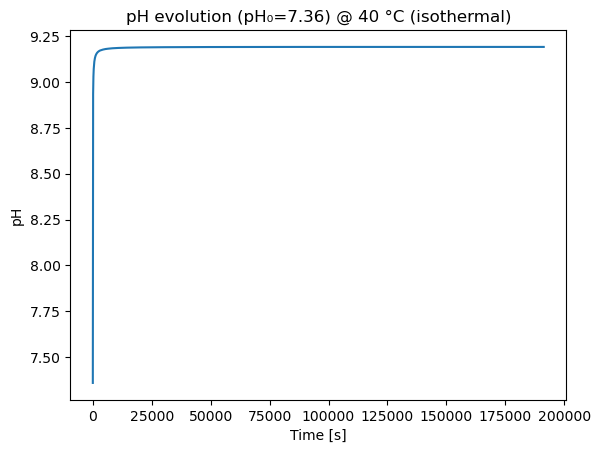

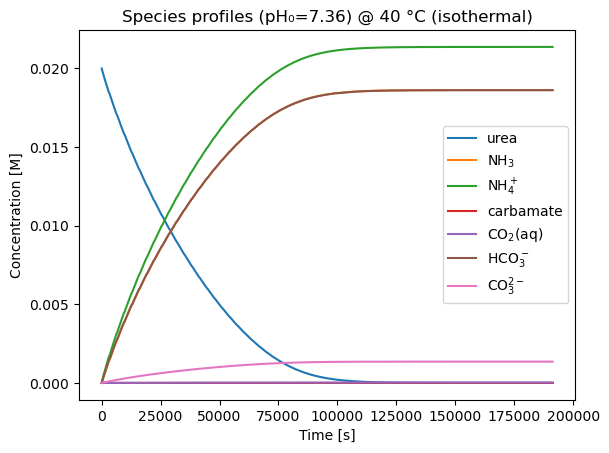